In [20]:
import pvlib as pvl
import pandas as pd
import numpy as np
import pvlib.spectrum as pvs
import matplotlib.pyplot as plt
import pathlib
import glob
import spectrl2

#### spectra_components (dict)
A dict of arrays. With the exception of wavelength, which has length 122, each array has shape (122, N) where N is the length of the input apparent_zenith. All values are spectral irradiance with units Wm⁻²nm⁻¹, except for wavelength, which is in nanometers. See spectra_components.

output dict: wavelength, dni_extra, dhi, dni, poa_sky_diffuse, poa_ground_diffuse, poa_direct, poa_global

#### Assumptions

In [ ]:
# assumptions from the technical report (same as pvlib sample except for rel_airmass model)
lat = 37
lon = -100
tilt = 37
azimuth = 180
pressure = 101300  # sea level, roughly
water_vapor_content = 0.5  # cm
tau500 = 0.1
ozone = 0.31  # atm-cm
albedo = 0.2

times = pd.date_range('1984-03-20 06:17', freq='h', periods=6, tz='Etc/GMT+7')
solpos = pvl.solarposition.get_solarposition(times, lat, lon)
aoi = pvl.irradiance.aoi(tilt, azimuth, solpos.apparent_zenith, solpos.azimuth)

relative_airmass = pvl.atmosphere.get_relative_airmass(solpos.apparent_zenith,
                                                   model='kastenyoung1989')

#### Arguments

In [22]:
# arguments
# solar zenith angle. [degrees]
apparent_zenith = solpos.apparent_zenith
# angle of incidence of the solar vector on the panel [degrees]
aoi = aoi
# panel tilt from horizontal. [degrees]
surface_tilt = tilt
# can be provided as a scalar value if albedo is not spectrally-dependent,
# or as a 122xN matrix where the first dimension spans the wavelength range and the second spans the number of simulations. [unitless]
ground_albedo = albedo
# surface pressure. [Pa]
surface_pressure = pressure
relative_airmass = relative_airmass
# atmospheric water vapor content. [cm]
precipitable_water = water_vapor_content
# atmospheric ozone content. [atm-cm] Hwo do we get this???
ozone = ozone
# aerosol turbidity at 500 nm. [unitless]
aerosol_turbidity_500nm = tau500
# day of year [1-365]. Must be provided if apparent_zenith is not a pandas.Series.
dayofyear=None
# aerosol single scattering albedo at 400nm. The default value of 0.945 is suggested in [1] for a rural aerosol model. [unitless]. Keep default.
scattering_albedo_400nm = 0.945
# angstrom turbidity exponent. The default value of 1.14 is suggested in [1] for a rural aerosol model. [unitless]. Keep default.
alpha=1.14
# wavelength variation factor [unitless]. Keep default.
wavelength_variation_factor = 0.095
# aerosol asymmetry factor (mean cosine of scattering angle). [unitless]. Keep default.
aerosol_asymmetry_factor = 0.65                            

#### Test spectral

In [33]:
spectral_test = pvs.spectrl2(apparent_zenith,
                             aoi,
                             surface_tilt,
                             ground_albedo,
                             surface_pressure,
                             relative_airmass,
                             precipitable_water,
                             ozone,
                             aerosol_turbidity_500nm,
                             )

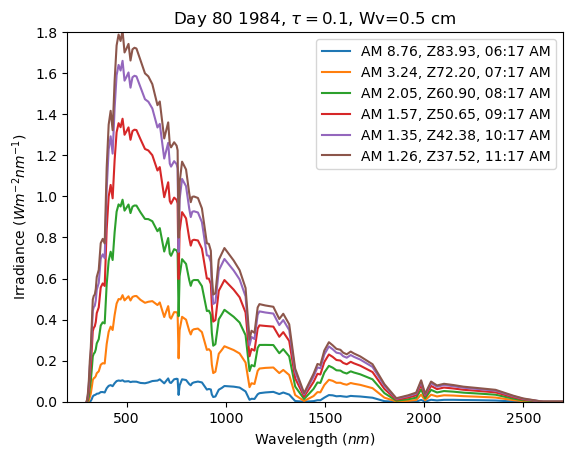

In [34]:
plt.figure()
plt.plot(spectral_test['wavelength'], spectral_test['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.title(r"Day 80 1984, $\tau=0.1$, Wv=0.5 cm")
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")
time_labels = times.strftime("%H:%M %p")
labels = [
    "AM {:0.02f}, Z{:0.02f}, {}".format(*vals)
    for vals in zip(relative_airmass, solpos.apparent_zenith, time_labels)
]
plt.legend(labels)
plt.show()

#### Solcast data example

##### Inputs

In [25]:
loc = 'Boulder_CO'
spectral_path = pathlib.Path(r'O:\1007\10079547 Innovation\Spectral Correction\Spectral 2026 update')
outputdir = spectral_path / loc
dtadir = pathlib.Path(r'C:\Users\umaakk\Documents\git_repos\FSSpectral3Review\data')
# poa_results = pathlib.Path(r"O:\1007\10079547 Innovation\Spectral Correction\Spectral 2026 update\pvsc_global_poa_30m.csv")


In [26]:
site_info = pd.read_csv(
    dtadir/"FARMS-NIT/farms_nit_site_info.csv"
    , index_col=0
)
# site_info

In [27]:
site_info.loc['Calgary_AL'] = dict(
    Latitude=51.00481522607504,
    Longitude=-113.98138900184489,
    local_tz='Etc/GMT+7',
    Elevation=1045)

In [28]:
# later loop this for loc in site_info
site = spectrl2.this_site_info(loc, site_info)
tmy, tmy_pressure, tmy_pwat, tmy_zenith, tmy_times = spectrl2.site_arguments(spectral_path, loc, dtadir)
# TO-DO: add tmy_aod to the fxn
tmy_solpos = pvl.solarposition.get_solarposition(tmy_times, site.latitude, site.longitude)

##### Calculate tracker angles

In [29]:
# Tracker Configuration
tracker_config = {
    'max_tracker_angle': 55,
    'pitch': 6.3462408,
    'module_length': 2.384,
    'axis_tilt': 0,
    'axis_azimuth': 0,
    'backtrack': True,
}

In [30]:
tracker_angles, tmy_tilt, tmy_aoi, tmy_relhum = spectrl2.spectral2_arguments(tmy, tmy_solpos, tracker_config)

In [31]:
spectral_solcast = pvs.spectrl2(tmy_zenith,
                             tmy_aoi,
                             tmy_tilt,
                             ground_albedo,
                             tmy_pressure,
                             tmy_relhum,
                             tmy_pwat,
                             ozone,
                             aerosol_turbidity_500nm,
                             )

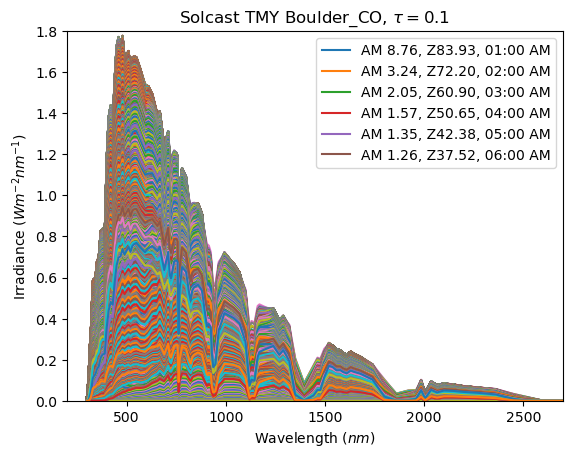

In [32]:
plt.figure()
plt.plot(spectral_solcast['wavelength'], spectral_solcast['poa_global'])
plt.xlim(200, 2700)
plt.ylim(0, 1.8)
plt.title(rf"Solcast TMY {loc}, $\tau=0.1$")
plt.ylabel(r"Irradiance ($W m^{-2} nm^{-1}$)")
plt.xlabel(r"Wavelength ($nm$)")
time_labels = tmy_times.strftime("%H:%M %p")
labels = [
    "AM {:0.02f}, Z{:0.02f}, {}".format(*vals)
    for vals in zip(relative_airmass, solpos.apparent_zenith, time_labels)
]
plt.legend(labels)
plt.show()